# Problem 1

## Importing libraries

In [0]:
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Comment to get non-deterministic results
np.random.seed(2)

In [45]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Problem 1.

**Building the Model**

1.    Forward and backward propagation for single exemples (see forward and backward functions);
    and for matrices (see forward_mbatch and backward_mbatch functions)
    
2.    This implemetation does not use any deep learning frameworks with automatic differentiation

3. We trained the model using the probability loss (cross entropy) as training criterion. See the loss function.

In [0]:
#Several functions in this class implementation are inspired from the NN 
#implemented in cours IFT6093

class NN(object):
    
    '''
    Arguments:
        input_dim: The input dimension
        output_dim: The output dimension
        hidden_dims: (h1 dimension, h2 dimension)
        n_hidden: number of hidden layers
        initialization: type of weigth initialization (zeros, normal or glorot)
    
    '''
    
    def __init__(self, input_dim, output_dim,hidden_dims=(1024,2048),n_hidden=2,
                 initialization='zeros', mode=',train', datapath=None,
                 model_path=None):
        
        self.indim = input_dim
        self.hd1 = hidden_dims[0] 
        self.hd2 = hidden_dims[1]
        self.n_hidden = n_hidden
        self.outd = output_dim
        self.W1 = np.zeros(shape=(hidden_dims[0], input_dim))
        self.b1 = np.zeros(hidden_dims[0])
        self.W2 = np.zeros(shape=(hidden_dims[1], hidden_dims[0]))
        self.b2 = np.zeros(hidden_dims[1])
        self.W3 = np.zeros(shape=(output_dim, hidden_dims[1]))
        self.b3 = np.zeros(output_dim)
        
        
        if initialization=='normal':
            self.initialize_weights_normal()
            
        if initialization=='glorot':
            self.initialize_weights_glorot()
           
        self.parameters = [self.W3, self.b3, self.W2, self.b2, self.W1, self.b1]
        
        
    def initialize_weights_normal(self):
        
        self.W1 = np.random.normal(size=(self.hd1, self.indim))
        self.W2 = np.random.normal(size=(self.hd2, self.hd1))
        self.W3 = np.random.normal(size=(self.outd, self.hd2))
        return self
    
    
    
    def initialize_weights_glorot(self):
        
        dl1 = np.sqrt(6/(self.indim + self.hd1))
        dl2 = np.sqrt(6/(self.hd1 + self.hd2))
        dl3 = np.sqrt(6/(self.hd2 + self.outd))
        self.W1 = np.random.uniform(low=(-dl1), high=dl1, size=(self.hd1, self.indim))
        self.W2 = np.random.uniform(low=(-dl2), high=dl2, size=(self.hd2, self.hd1))
        self.W3 = np.random.uniform(low=(-dl3), high=dl3, size=(self.outd, self.hd2))
        return self
        
        
    #Method from NN implemented in cours IFT6093
    
    def activation(self, x):
      return (x > 0) * x
    
    #line 85

    
    # forward for single exemple
    def forward(self,x):
                
        a1 = np.dot (self.W1, x) + self.b1 
        h1 = self.activation (a1)
        a2 = np.dot (self.W2, h1) + self.b2
        h2 = self.activation (a2)
        oa = np.dot (self.W3, h2) + self.b3
        os = self.softmax (oa, axis=0)
        
        return a1, h1, a2, h2, oa, os
    
    def setZero(self, a ):
        a[ np.abs( a ) <= zero ] = zero
        return a

    #Loss function using probability loss (cross entropie)
    def loss (self, y, os):
        return (y * (-np.log(os))).sum()
    
    #ans softmax methods from NN implemented in cours IFT6093
    
    def softmax(self, x, axis=1):
      e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
      return e_x / e_x.sum(axis=axis, keepdims=True)


    #Backward for single exemple
    def backward(self, x, y, a1, h1, a2, h2, oa, os, weight_decay=0, cache=None):
        
        grad_oa = os - y
        grad_W3 = np.outer (grad_oa, h2) + weight_decay * self.W3
        grad_b3 = grad_oa
        grad_h2 = np.dot (self.W3.T, grad_oa)
        grad_a2 = (a2 > 0) * grad_h2
        grad_W2 = np.outer (grad_a2, h1) + weight_decay * self.W2
        grad_b2 = grad_a2
        grad_h1 = np.dot (self.W2.T, grad_a2)
        grad_a1 = (a1 > 0) * grad_h1
        grad_W1 = np.outer (grad_a1, x) + weight_decay * self.W1
        grad_b1 = grad_a1
        grads=[grad_W3, grad_b3, grad_W2, grad_b2, grad_W1, grad_b1]
   
        return grads



    def update(self, grads, learning_rate):
        for p, grad in zip(self.parameters, grads):
            p -= learning_rate * grad
        
    #line 201   

    #Sthocastic gradient descent method (litteral)
    def train_SGD(self, x, y_onehot, n, learning_rate=1e-1, weight_decay=0):
                
        y = y_onehot
        losses = 0
        if (n==1):
            a1, h1, a2, h2, oa, os = self.forward(x)
            grads = self.backward(x, y, a1, h1, a2, h2, oa, os)
            self.update(grads, learning_rate)
            loss = self.loss(y, os)
            losses += loss  
            average_loss = losses / x.shape[0]
        else:    
            for j in range(x.shape[0]):
                a1, h1, a2, h2, oa, os = self.forward(x[j])
                grads = self.backward(x[j], y[j], a1, h1, a2, h2, oa, os)
                self.update(grads, learning_rate)
                loss = self.loss(y[j], os)
                losses += loss     
            average_loss = losses / x.shape[0]
                
        return average_loss
    
    
    def prediction_SGD (self, x):
        predictions = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            _, _, _, _, _, os = self.forward(x[i])
            predictions[i] = os.argmax()
                
        return predictions
                
    
    def accuracy_SGD (self, prediction, y):
        accuracies=0
        for i in range (y.shape[0]):
            accuracies+=(prediction[i]==y[i])
            
        return accuracies / y.shape[0]
    
    
    def test_SGD(self, x, y_onehot, y):
        pred=np.zeros(y.shape[0])
        avg_loss=0
        for i in range (x.shape[0]):
            _, _, _, _, _, os = self.forward(x[i])
            loss=self.loss (y_onehot[i], os)
            avg_loss+=loss
            pred[i]=os.argmax()
            
        accuracy=self.accuracy_SGD(pred, y)    
        return avg_loss / x.shape[0] , accuracy
    
   
    #Sthocastic Gradien Descent method with minibatch (using matrices)
    def forward_mbatch(self, x):
                
        a1 = np.dot ( x, self.W1.T) + self.b1
        h1 = self.activation (a1)
        a2 = np.dot (h1, self.W2.T) + self.b2
        h2 = self.activation (a2)
        oa = np.dot (h2, self.W3.T) + self.b3
        os = self.softmax (oa, axis=1)
                
        return a1, h1, a2, h2, oa, os
    
    #line 303
        
    def backward_mbatch(self, x, y, a1, h1, a2, h2, oa, os, batch_n, weight_decay=0):
                
        batch_n = x.shape[0]
        bgrad_oa = os - y
        bgrad_W3 = np.dot (bgrad_oa.T, h2) / batch_n  + weight_decay * self.W3
        bgrad_b3 = bgrad_oa.mean(axis=0)
        bgrad_h2 = np.dot (bgrad_oa, self.W3)
        bgrad_a2 = (a2 > 0) * bgrad_h2
        bgrad_W2 = np.dot (bgrad_a2.T, h1) / batch_n  + weight_decay * self.W2
        bgrad_b2 = bgrad_a2.mean(axis=0)
        bgrad_h1 = np.dot (bgrad_a2, self.W2)
        bgrad_a1 = (a1 > 0) * bgrad_h1
        bgrad_W1 = np.dot (bgrad_a1.T, x) / batch_n  + weight_decay * self.W1
        bgrad_b1 = bgrad_a1.mean(axis=0)
        bgrads=[bgrad_W3, bgrad_b3, bgrad_W2, bgrad_b2, bgrad_W1, bgrad_b1]
   
        return bgrads

    #line 360

    #Method taken fron homwork 3 in cours IFT6093
    def loss_mbatch(self, os, y):
        return (y * (-np.log(os))).sum(axis=1).mean(axis=0)     
        
    
    #training with minibatch gradient decent
    def train_mbatch(self, x, y_onehot, mb_size=100, learning_rate=1e-1, weight_decay=0):
                
        average_loss=0
        for i in range (0, x.shape[0], mb_size):
            xi = x[i:(i+mb_size)]
            yi = y_onehot[i:(i+mb_size)]
        
            #losses = 0
            a1, h1, a2, h2, oa, os = self.forward_mbatch(xi)
            grads = self.backward_mbatch (xi, yi,a1, h1, a2, h2,oa, os, mb_size)
            self.update(grads, learning_rate)
            average_loss = self.loss_mbatch(os, yi) 
                          
        return average_loss
    
    
    #line 385
    
    def prediction_mbatch (self, x):
        _, _, _, _, _, os = self.forward_mbatch(x)
        return os.argmax(axis=1)
    

    def accuracy_mbatch (self, prediction, y):
        accuracy = np.zeros(y.shape[0])
        accuracy = prediction == y
        return accuracy.mean(axis=0)
    

    def test_mbatch(self, x, y_onehot, y):
        _, _, _, _, _, os = self.forward_mbatch(x)
        loss = self.loss_mbatch (os, y_onehot)
        accuracy=self.accuracy_mbatch (os.argmax(axis=1), y)
        return loss, accuracy
    
    
    def finite_difference():
        
        pass


## Function onehot

In [0]:
#function taken from IFT6093 cours
def onehot(y, n_classes):
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

## Data loader

Getting data from the mnist.pkl.gz file

In [0]:
import gzip, pickle
with gzip.open('gdrive/My Drive/mnist.pkl.gz','rb') as ff :
    u = pickle._Unpickler( ff )
    u.encoding = 'latin1'
    train, val, test = u.load()
    
X_tr, y_tr= train
X_v, y_v = val
X_t, y_t = test

Processing data set

In [49]:
# train_data randomization
#indices_t = list(range(len(X_tr)))
#shuffle(indices_t)
#X_train, y_train=  X_tr[indices_t[:]], y_tr[indices_t[:]]

# validation_data randomization
#indices_v = list(range(len(X_v)))
#shuffle(indices_v)
#X_valid, y_valid = X_v[indices_v[:]], y_v[indices_v[:]]


X_train = np.array (X_tr)
y_train = np.array (y_tr)
X_valid= np.array (X_v)
y_valid= np.array (y_v)
X_test = np.array (X_t)
y_test = np.array (y_t)


#geting onehot(y)
digit_y_train_onehot= onehot (y_train, 10)
digit_y_valid_onehot= onehot (y_valid, 10)
digit_y_test_onehot= onehot (y_test, 10)


print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_valid shape = ', X_valid.shape)
print('y_valid shape = ', y_valid.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (50000, 784)
y_train shape =  (50000,)
X_valid shape =  (10000, 784)
y_valid shape =  (10000,)
X_test shape =  (10000, 784)
y_test shape =  (10000,)


Learning curves function

In [0]:
#This function returns the learning curves grafics

def learning_curves(losses_train, accs_train, losses_valid, accs_valid,
                    h1, h2):
  
 
  plt.figure(figsize=(12, 4))
  axis = plt.subplot(1, 2, 1)
  axis.plot(range(1, epochs+1), losses_train, label='train')
  axis.plot(range(1, epochs+1), losses_valid, label='valid')
  
  axis.legend()
  axis.set_ylabel('Loss')
  axis.set_xlabel('Epochs')
  plt.title(('h_1 = ', h1, 'h_2 =', h2))
  
  
  axis = plt.subplot(1, 2, 2)
  axis.plot(range(1, epochs+1), accs_train, label='train')
  axis.plot(range(1, epochs+1), accs_valid, label='valid')
  
  axis.legend()
  axis.set_ylabel('Accuracy')
  axis.set_xlabel('Epochs')
  plt.title(('h_1 = ', h1, 'h_2 =', h2))
  


**Building the model .**

3. Training  the MLP using the probability loss (
cross entropy
) as training criterion.  


In this part we use sthocastic gradient descent to optimize the number of hidden unites to be between 0.5 M and 1M

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Validation accuracy after 10 epoch training for h1=  500 h2 = 200 :  0.9764
Validation accuracy after 10 epoch training for h1=  500 h2 = 300 :  0.9784
Validation accuracy after 10 epoch training for h1=  800 h2 = 200 :  0.9782
Validation accuracy after 10 epoch training for h1=  800 h2 = 300 :  0.978


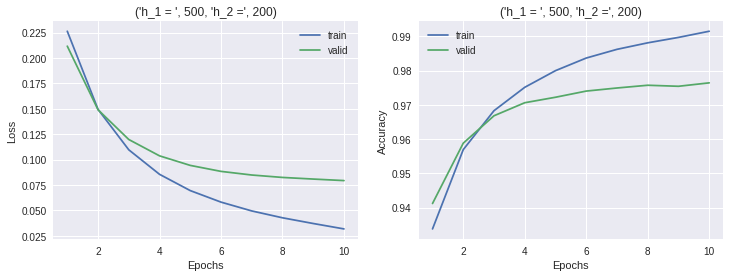

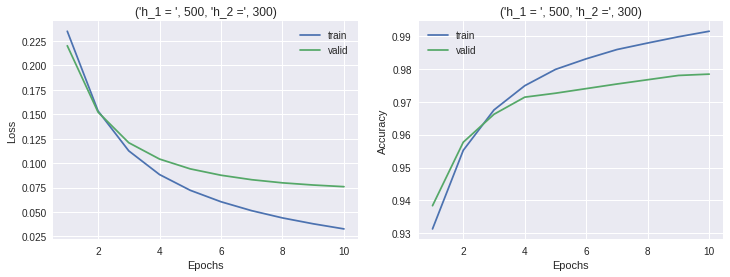

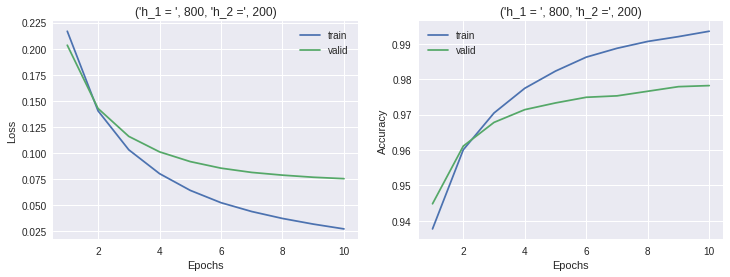

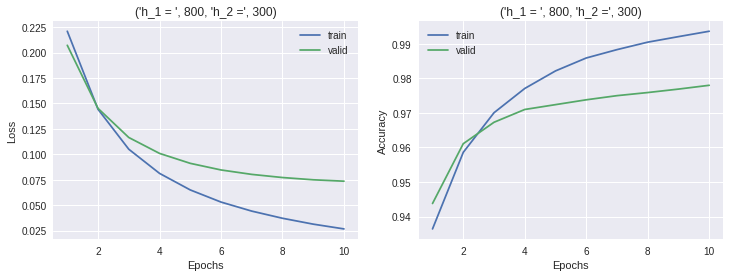

In [51]:
#3. Training the model with sthocastic gradient descent

zero=10**-15


for i, h1 in enumerate([500, 800]):
  
  for j, h2 in enumerate ([200, 300]):
  
  
    NN_SGD = NN(784, 10, hidden_dims=(h1, h2), initialization='glorot')
    
    # Model training 
    losses_train, accs_train = [], []
    losses_valid, accs_valid = [], []

    epochs=10

    for epoch in range (epochs):
  
      loss = NN_SGD.train_mbatch(X_train, digit_y_train_onehot, mb_size=100)

    #Test in validation and test set: test_mbatch(x_t, y_t_o, y_t)
    
      loss_train, acc_train = NN_SGD.test_mbatch(X_train, digit_y_train_onehot, y_train)
      loss_valid, acc_valid = NN_SGD.test_mbatch(X_valid, digit_y_valid_onehot, y_valid) 
      
    
      losses_train.append(loss_train) 
      accs_train.append(acc_train)
      losses_valid.append(loss_valid)
      accs_valid.append(acc_valid)
      
    valid_acc_epoc_90_100 = np.array(accs_valid[90:])
    valid_acc_mean_epoc_90_100 = valid_acc_epoc_90_100.mean()
      
    #print ('Mean validation accuracy from the last 10 epoch for h1= ', h1, 'h2 =', h2, ': ', valid_acc_mean_epoc_90_100)
    print ('Validation accuracy after 10 epoch training for h1= ', h1, 'h2 =', h2, ': ', acc_valid)
    
    learning_curves(losses_train, accs_train, losses_valid, accs_valid, h1, h2)

###  All configurations had similar results. The configuration h1=500, h2=300 was lightly higher, with a mean accuracy 97.84 %. Then we decide to use this configuration.

## Initialization

Model architecture: 

imput dimensions = 780, h1=500, h2=300, parameters number=545800


activation: Relu in both hidden layers


learning rate 1e-3


minibatc size=50

In [0]:
# Function to plot loss under different initialization weight types

def graf_initialization (epochs, zeros_losses, normal_losses, glorot_losses):
  fig = plt.figure()
  plt.plot(range(epochs),  zeros_losses, label='zeros')
  plt.plot(range(epochs), normal_losses, label='normal')
  plt.plot(range(epochs), glorot_losses, label='glorot')

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
 
  plt.title("Initialization")

  plt.legend()
  plt.show()

Training with initialization: zeros, normal, glorot. Epoch 10

In [54]:
#1. Weigths initialization data from dataloader
zero=10**-15
print('Weigths initialization')

# Set timer
import time
start_time = time.time()

#training 10 epochs for each initialization type
epochs=10

zeros_losses=[]
normal_losses=[]
glorot_losses=[]
weigths=['zeros', 'normal', 'glorot']

for i, init in enumerate(weigths, 0):
    
    NN_digits= NN(784, 10, hidden_dims=(500,300), initialization=init)

    for epoch in range (epochs): 
    
        loss=NN_digits.train_mbatch(X_train, digit_y_train_onehot, mb_size=50, learning_rate=1e-3)
        if (init=='zeros'):
            zeros_losses.append(loss)
        if (init == 'normal'):
            normal_losses.append(loss)
        if (init == 'glorot'):
            glorot_losses.append(loss)
            
time_mb = time.time() - start_time
print('Time with minibatch gradient decent implementation: %f seconds\n' % time_mb)





Weigths initialization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:211: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in multiply


Time with minibatch gradient decent implementation: 427.063977 seconds



Make graphic for different weigths initialization

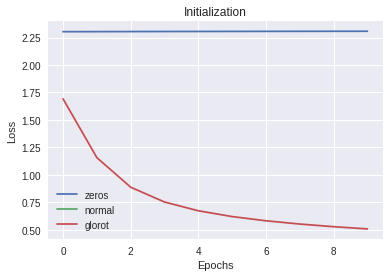

In [55]:

graf_initialization(epochs, zeros_losses, normal_losses, glorot_losses)

Results: 

Zero initialization did not result in any changes in gradients, then there was no optimization.

Normai initialization, moves slightely, but very soon behave in th same way than zero initialization, maybe because it has mean=0.

Glorot initialization promotes rapid change in gradients and allows optimization.



# =============================================================================================

# 2. Hyperparameter Search

## Checking the best hyperparameters with validation dataset

### Hyperparameter search function

In [0]:
# Train the model using different hyperparameters, like mini-batch size, learning rate and epochs number
# x_ds is the dataset to train, y_ds is the target dataset.


def hyperparameter_checking(x_train_ds,y_train_ds,x_valid_ds,y_valid_ds,epochs,minibatch,learningrate, weight_decay=0, verbose=False):
    x = x_train_ds
    print('x.shape = ', x.shape)
    y = y_train_ds
    y = onehot(y,10)
    print('y.shape = ', y.shape)
    y_valid_onehot=onehot(y_valid_ds,10)
    
    # input_dim, output_dim,hidden_dims,n_hidden=2,mode=',train',
    # datapath=None,model_path=None
    NN_mbatch_1= NN(784, 10, hidden_dims=(500,300),initialization='glorot')
    loss_training_arr=[]
    loss_validation_arr=[]
    loss_mbatch_1=0
    for epoch in range (epochs): 
        #x, y_onehot, mb_size=100, learning_rate=1e-1, weight_decay=0
        loss_mbatch_1=NN_mbatch_1.train_mbatch(x, y, mb_size=minibatch,learning_rate=learningrate, weight_decay=0)
        if verbose:
            print('epoch ', epoch, ' loss ', loss_mbatch_1)
        loss,accuracy=NN_mbatch_1.test_mbatch(x_valid_ds,y_valid_onehot,y_valid_ds)
        loss_training_arr.append(loss_mbatch_1)
        loss_validation_arr.append(loss)
    print('epoch ', epoch, ' loss ', loss_mbatch_1)
    return loss_training_arr,loss_validation_arr,accuracy,NN_mbatch_1 # accuracy of validation test

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Display differents graphs using different hyperparameters saved in arrays.
# Input variables are arrays with the same lenght, with the values to graph

def show_graphs(minibatch_arr,epoch_arr,learningrate_arr,loss_arr):
# define a list of markevery cases to plot
    cases=[]
    x_values=[]
    y_values=[]
    for i in range(len(minibatch_arr)):
        cases.append([minibatch_arr[i],epoch_arr[i],learningrate_arr[i]])
        # define the data for cartesian plots
        x_values.append(range(epoch_arr[i]))
        y_values.append(loss_arr[i])
    # define the figure size and grid layout properties
    figsize = (12, 10)
    cols = 2
    gs = gridspec.GridSpec(len(cases) // cols + 1, cols)
    gs.update(hspace=0.4)
    
    fig1 = plt.figure(num=1, figsize=figsize)
    ax = []
    for i, case in enumerate(cases):
        row = (i // cols)
        col = i % cols
        ax.append(fig1.add_subplot(gs[row, col]))
        ax[-1].set_title('Minibatch=%s, Epoch=%s, Learning=%s' % (str(case[0]),str(case[1]),str(case[2])))
        ax[-1].plot(x_values[i], y_values[i], 'o', ls='-', ms=4, markevery=1)

## Using different hyperparameters with validation set and Glorot initialization:

## * Changing Mini-batch size:

### With different Mini-batch sizes, Epoch=100, Learning rate=0.1:

In [0]:
x_ds=X_train
y_ds=y_train
x_valid_ds=X_valid
y_valid_ds=y_valid

In [0]:
loss_arr_0=[] #training loss array
loss_arr_valid_0=[] #valid loss array
epoch_arr_0=[] #epoch array (save the epoch used on each mini-batch)
acc_arr_0=[] # accuracy with validation set array 
lr_0=1e-1 #learning rate used.
epoch_0=10 #total epoch 
for i, minibatch in enumerate([50,100,150,500]):
    loss_array,loss_array_valid,acc_valid,nn_model=hyperparameter_checking(x_ds,y_ds,x_valid_ds,y_valid_ds,epoch_0,minibatch,lr_0)
    loss_arr_0.append(loss_array)
    loss_arr_valid_0.append(loss_array_valid)
    epoch_arr_0.append(epoch_0)
    acc_arr_0.append(acc_valid)
    print('Accuracy: %s' % str(acc_valid))

x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.004108463880347624
Accuracy: 0.9794
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.02919253080312227
Accuracy: 0.9762
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.017556003479687318
Accuracy: 0.9759
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.21241063096265345
Accuracy: 0.9607


In [0]:
epoch_arr_0=[10,10,10,10]

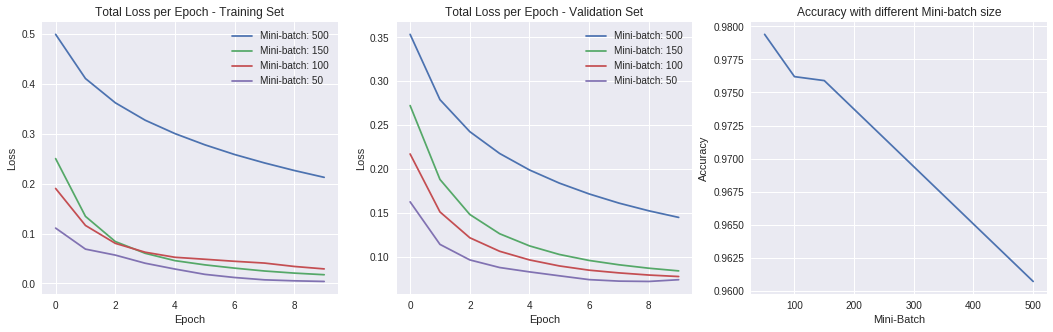

In [0]:
minibatch_arr=[50,100,150,500]
fig, ax = plt.subplots(1,3,figsize=(18, 5))
# plt.xlabel('Epoch')
ax[2].plot(minibatch_arr, acc_arr_0, markevery=1)
ax[2].set_xlabel('Mini-Batch')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Accuracy with different Mini-batch size')
ax[2].grid(True)
ax[0].plot(range(epoch_arr_0[3]), loss_arr_0[3], label='Mini-batch: %s' % str(minibatch_arr[3]))
ax[0].plot(range(epoch_arr_0[2]), loss_arr_0[2], label='Mini-batch: %s' % str(minibatch_arr[2]))
ax[0].plot(range(epoch_arr_0[1]), loss_arr_0[1], label='Mini-batch: %s' % str(minibatch_arr[1]))
ax[0].plot(range(epoch_arr_0[0]), loss_arr_0[0], label='Mini-batch: %s' % str(minibatch_arr[0]))
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per Epoch - Training Set')
ax[1].plot(range(epoch_arr_0[3]), loss_arr_valid_0[3], label='Mini-batch: %s' % str(minibatch_arr[3]))
ax[1].plot(range(epoch_arr_0[2]), loss_arr_valid_0[2], label='Mini-batch: %s' % str(minibatch_arr[2]))
ax[1].plot(range(epoch_arr_0[1]), loss_arr_valid_0[1], label='Mini-batch: %s' % str(minibatch_arr[1]))
ax[1].plot(range(epoch_arr_0[0]), loss_arr_valid_0[0], label='Mini-batch: %s' % str(minibatch_arr[0]))
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per Epoch - Validation Set')
plt.show()

4


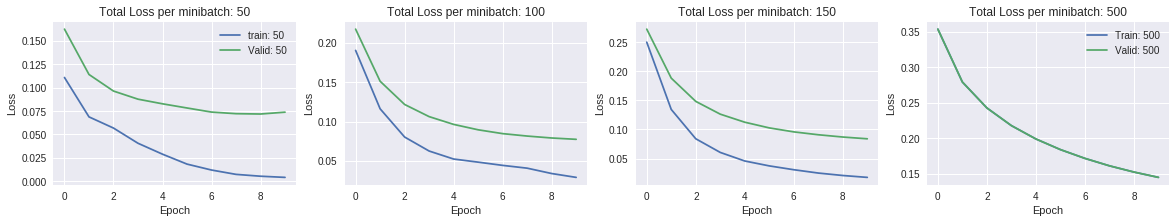

In [0]:
print(len(loss_arr_0)) 
  
minibatch_arr=[50,100,150,500]
fig, ax = plt.subplots(1,4,figsize=(20, 3))

plt.xlabel('Epoch')


ax[0].plot(range(epoch_arr_0[0]), loss_arr_0[0], label='train: %s' % str(minibatch_arr[0]))
ax[0].plot(range(epoch_arr_0[0]), loss_arr_valid_0[0], label='Valid: %s' % str(minibatch_arr[0]))
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per minibatch: %s' % str(minibatch_arr[0]))

ax[1].plot(range(epoch_arr_0[1]), loss_arr_0[1], label='Train: %s' % str(minibatch_arr[1]))
ax[1].plot(range(epoch_arr_0[1]), loss_arr_valid_0[1], label='Vallid: %s' % str(minibatch_arr[1]))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per minibatch: %s' % str(minibatch_arr[1]))

ax[2].plot(range(epoch_arr_0[2]), loss_arr_0[2], label='Train: %s' % str(minibatch_arr[2]))
ax[2].plot(range(epoch_arr_0[2]), loss_arr_valid_0[2], label='Valid: %s' % str(minibatch_arr[2]))
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title('Total Loss per minibatch: %s' % str(minibatch_arr[2]))

ax[3].plot(range(epoch_arr_0[3]), loss_arr_valid_0[3], label='Train: %s' % str(minibatch_arr[3]))
ax[3].plot(range(epoch_arr_0[3]), loss_arr_valid_0[3], label='Valid: %s' % str(minibatch_arr[3]))
ax[3].legend()
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].set_title('Total Loss per minibatch: %s' % str(minibatch_arr[3]))



plt.show()

### We obtain a better accuracy when we choose a smaller Mini-Batch size. 

## * Changing Learning-Rate:

### With different Learning Rates, Epoch=100, Minibath size=50:

In [0]:
x_ds=X_train
y_ds=y_train
x_valid_ds=X_valid
y_valid_ds=y_valid

In [56]:
lr_arr_1=[] #learning rate array.
loss_arr_1=[]   #training loss array
loss_arr_valid_1=[] #valid loss array
epoch_arr_1=[] #epoch array (save the epoch used on each mini-batch)
acc_arr_1=[] # accuracy with validation set array 
epoch_1=10  #total epoch 
mb=50
for i, learningrate in enumerate([0.1,0.01,0.001]):
    loss_array,loss_array_valid,acc_valid,nn_model=hyperparameter_checking(x_ds,y_ds,x_valid_ds,y_valid_ds,epoch_1,mb,learningrate)
    loss_arr_1.append(loss_array)
    loss_arr_valid_1.append(loss_array_valid)
    epoch_arr_1.append(epoch_1)
    acc_arr_1.append(acc_valid)
    print('Accuracy: %s' % str(acc_valid))

x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.004126474689100925
Accuracy: 0.979
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.11802140828831599
Accuracy: 0.9609
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.5065197406474307
Accuracy: 0.9087


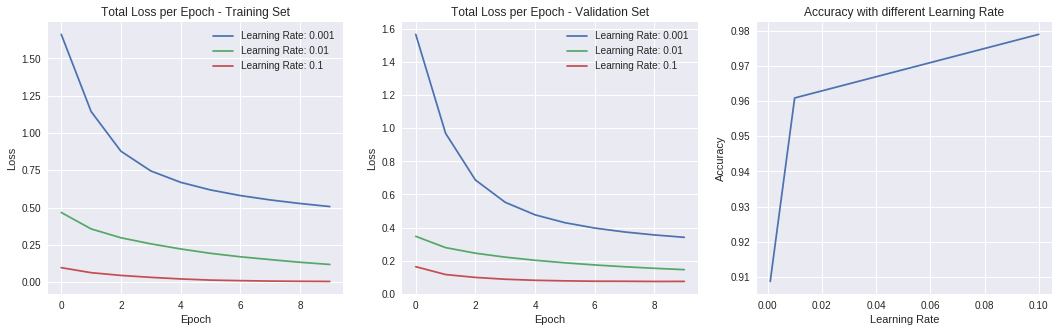

In [57]:
learningrate_arr=[0.1,0.01,0.001]
fig, ax = plt.subplots(1,3,figsize=(18, 5))
# plt.xlabel('Epoch')
ax[2].plot(learningrate_arr, acc_arr_1, markevery=1)
ax[2].set_xlabel('Learning Rate')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Accuracy with different Learning Rate')
ax[2].grid(True)
ax[0].plot(range(epoch_arr_1[2]), loss_arr_1[2], label='Learning Rate: %s' % str(learningrate_arr[2]))
ax[0].plot(range(epoch_arr_1[1]), loss_arr_1[1], label='Learning Rate: %s' % str(learningrate_arr[1]))
ax[0].plot(range(epoch_arr_1[0]), loss_arr_1[0], label='Learning Rate: %s' % str(learningrate_arr[0]))
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per Epoch - Training Set')
ax[1].plot(range(epoch_arr_1[2]), loss_arr_valid_1[2], label='Learning Rate: %s' % str(learningrate_arr[2]))
ax[1].plot(range(epoch_arr_1[1]), loss_arr_valid_1[1], label='Learning Rate: %s' % str(learningrate_arr[1]))
ax[1].plot(range(epoch_arr_1[0]), loss_arr_valid_1[0], label='Learning Rate: %s' % str(learningrate_arr[0]))
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per Epoch - Validation Set')
plt.show()

3


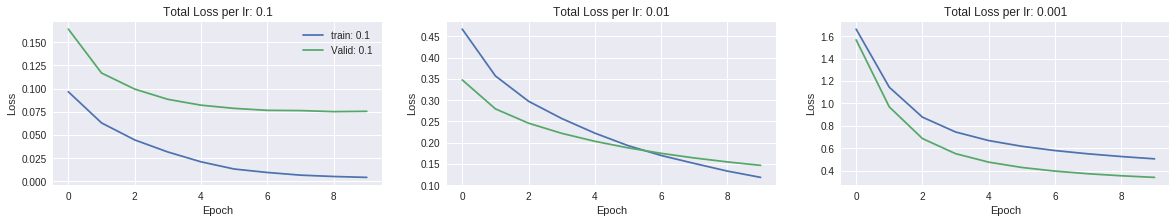

In [58]:
print(len(loss_arr_1)) 
  
learningrate_arr=[0.1,0.01,0.001]
fig, ax = plt.subplots(1,3,figsize=(20, 3))

plt.xlabel('Epoch')


ax[0].plot(range(epoch_arr_1[0]), loss_arr_1[0], label='train: %s' % str(learningrate_arr[0]))
ax[0].plot(range(epoch_arr_1[0]), loss_arr_valid_1[0], label='Valid: %s' % str(learningrate_arr[0]))
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per lr: %s' % str(learningrate_arr[0]))

ax[1].plot(range(epoch_arr_1[1]), loss_arr_1[1], label='Train: %s' % str(learningrate_arr[1]))
ax[1].plot(range(epoch_arr_1[1]), loss_arr_valid_1[1], label='Valid %s' % str(learningrate_arr[1]))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per lr: %s' % str(learningrate_arr[1]))

ax[2].plot(range(epoch_arr_1[2]), loss_arr_1[2], label='Train: %s' % str(learningrate_arr[2]))
ax[2].plot(range(epoch_arr_1[2]), loss_arr_valid_1[2], label='Valid: %s' % str(learningrate_arr[2]))
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title('Total Loss per lr: %s' % str(learningrate_arr[2]))




plt.show()

### We get a better accuracy if we choose a  learning rate of 0.1

## * Weight decay:

###  Epochs = 10, Learning Rates=0.1, Minibath size=50:

In [0]:
x_ds=X_train
y_ds=y_train
x_valid_ds=X_valid
y_valid_ds=y_valid

In [66]:
lr_arr_2=[] #learning rate array.
loss_arr_2=[]   #training loss array
loss_arr_valid_2=[] #valid loss array
epoch_arr_2=[] #epoch array (save the epoch used on each mini-batch)
acc_arr_2=[] # accuracy with validation set array 
learning_rate=0.1
mb=50
epochs=10
for i, decay in enumerate([0, 0.1, 0.01, 0.001]):
    loss_array,loss_array_valid,acc_valid,nn_model=hyperparameter_checking(x_ds,y_ds,x_valid_ds,y_valid_ds,epochs,mb,learning_rate, decay)
    loss_arr_2.append(loss_array)
    loss_arr_valid_2.append(loss_array_valid)
    epoch_arr_2.append(epochs)
    acc_arr_2.append(acc_valid)
    print('Accuracy: %s' % str(acc_valid))

x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.005681257446976644
Accuracy: 0.98
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.0038237709215993127
Accuracy: 0.978
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.006880441911116767
Accuracy: 0.9799
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.004917021272203008
Accuracy: 0.9801


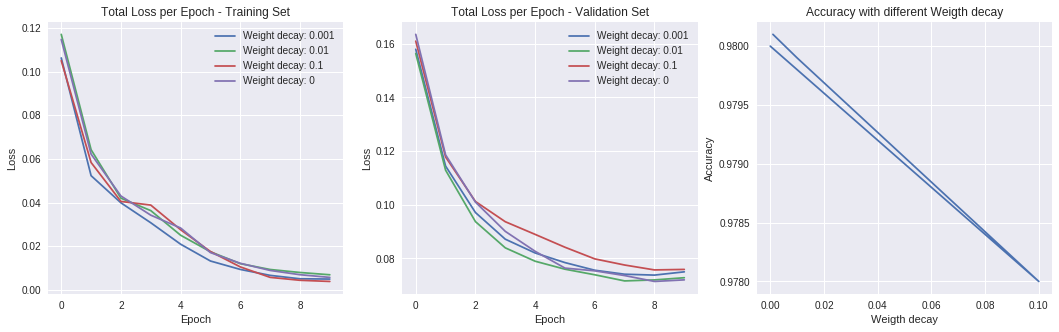

In [85]:
decay_arr=[0, 0.1, 0.01, 0.001]
fig, ax = plt.subplots(1,3,figsize=(18, 5))
# plt.xlabel('Epoch')
ax[2].plot(decay_arr, acc_arr_2, markevery=1)
ax[2].set_xlabel('Weigth decay')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Accuracy with different Weigth decay')
ax[2].grid(True)
ax[0].plot(range(epoch_arr_2[3]), loss_arr_2[3], label='Weight decay: %s' % str(decay_arr[3]))
ax[0].plot(range(epoch_arr_2[2]), loss_arr_2[2], label='Weight decay: %s' % str(decay_arr[2]))
ax[0].plot(range(epoch_arr_2[1]), loss_arr_2[1], label='Weight decay: %s' % str(decay_arr[1]))
ax[0].plot(range(epoch_arr_2[0]), loss_arr_2[0], label='Weight decay: %s' % str(decay_arr[0]))
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per Epoch - Training Set')
ax[1].plot(range(epoch_arr_2[3]), loss_arr_valid_2[3], label='Weight decay: %s' % str(decay_arr[3]))
ax[1].plot(range(epoch_arr_2[2]), loss_arr_valid_2[2], label='Weight decay: %s' % str(decay_arr[2]))
ax[1].plot(range(epoch_arr_2[1]), loss_arr_valid_2[1], label='Weight decay: %s' % str(decay_arr[1]))
ax[1].plot(range(epoch_arr_2[0]), loss_arr_valid_2[0], label='Weight decay: %s' % str(decay_arr[0]))
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per Epoch - Validation Set')
plt.show()

4


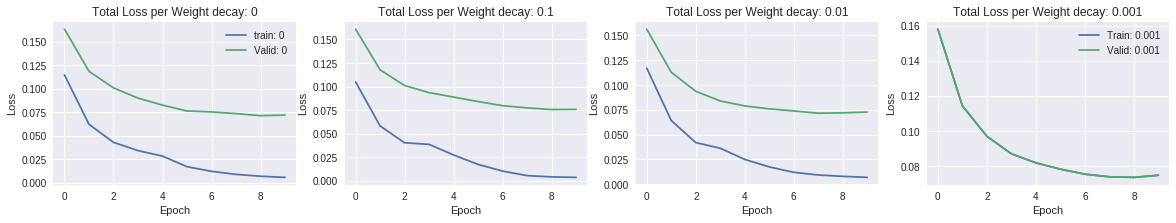

In [72]:
print(len(loss_arr_2)) 
  
decay_arr=[0, 0.1, 0.01, 0.001]
fig, ax = plt.subplots(1,4,figsize=(20, 3))

plt.xlabel('Epoch')


ax[0].plot(range(epoch_arr_2[0]), loss_arr_2[0], label='train: %s' % str(decay_arr[0]))
ax[0].plot(range(epoch_arr_2[0]), loss_arr_valid_2[0], label='Valid: %s' % str(decay_arr[0]))
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per Weight decay: %s' % str(decay_arr[0]))

ax[1].plot(range(epoch_arr_2[1]), loss_arr_2[1], label='Train: %s' % str(decay_arr[1]))
ax[1].plot(range(epoch_arr_2[1]), loss_arr_valid_2[1], label='Vallid: %s' % str(decay_arr[1]))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per Weight decay: %s' % str(decay_arr[1]))

ax[2].plot(range(epoch_arr_2[2]), loss_arr_2[2], label='Train: %s' % str(decay_arr[2]))
ax[2].plot(range(epoch_arr_2[2]), loss_arr_valid_2[2], label='Valid: %s' % str(decay_arr[2]))
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title('Total Loss per Weight decay: %s' % str(decay_arr[2]))

ax[3].plot(range(epoch_arr_2[3]), loss_arr_valid_2[3], label='Train: %s' % str(decay_arr[3]))
ax[3].plot(range(epoch_arr_2[3]), loss_arr_valid_2[3], label='Valid: %s' % str(decay_arr[3]))
ax[3].legend()
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].set_title('Total Loss per Weight decay: %s' % str(decay_arr[3]))



plt.show()

### The weight decay giving the lowest loss is near to zero.

### The best hyperparameters to train the model are Mini-batch size: 50, learning Rate: 0.1 and Weigth decay = 0

## Training the model:

### Training the model with Mini-batch size=50,  Learning rate=0.1,  weigth decay = 0, epoch = 10 

In [0]:
loss_arr=[]
epochs=10
mb=50
lr=1e-1
decay = 0
x=X_train
y=onehot(y_train,10)
# input_dim, output_dim,hidden_dims,n_hidden=2,mode=',train',
# datapath=None,model_path=None
NN_mnist= NN(784, 10, hidden_dims=(500,300),initialization='glorot')
for epoch in range (epochs): 
    #x, y_onehot, mb_size=100, learning_rate=1e-1, weight_decay=0
    loss_mbatch_1=NN_mnist.train_mbatch(x, y, mb, lr, decay )
    

### The accuracy obtained by the model using the training set is:

In [89]:

loss_test, accuracy_test=NN_mnist.test_mbatch (X_test, digit_y_test_onehot, y_test)

print('loss test =', loss_test)

print('accuracy_test =', accuracy_test)

loss test = 0.06517239127313937
accuracy_test = 0.9802


### Getting the predictions for test set:

In [0]:
mnist_predicction = NN_mnist.prediction_mbatch(X_test)

np.savetxt("gdrive/My Drive/mnist_prediction_new.csv", mnist_predicction, delimiter=",")

# =============================================================================================

# 3. Finite difference

In [0]:
#Approximation of the gradient of the loos at the end of training, with respect to W3 
# (the second layer weigths) with to the first p = min(10;m) elements of W3.


#function to calculate the finite difference for  

def loop_finite_diff(self, x, y, epsilon=1e-5):
        a1, h1, a2, h2, oa, os = self.forward(x)
        grads = self.backward(x, y, a1, h1, a2, h2, oa, os)
        loss = self.loss(y, os)
        
        grads_finite_diff = []
        
        for p in self.parameters[0]:
            grad_fdiff = np.zeros(shape=p.shape)
            for i, v in np.ndenumerate(p):
                p[i] += epsilon
                _, _, _, _, _, os = self.forward(x)
                loss_diff = self.loss(os, y)
                grad_fdiff[index] = (loss_diff - loss) / epsilon
                p[index] -= epsilon
            grads_finite_diff.append(grad_fdiff)
        return gradients_finite_diff

In [93]:
#1. epsilon = 1 / N

#Use at least 5 values of N from the set {k10**i : i E {0; : : : ; 5g} k E {1, 5}}
epsilon=[]
N = []
for exp in range (1, 6, 2):
    a= 10**exp
    N.append(a)
for exp in range (1, 5, 2):
    b= 5*10**exp
    N.append(b)
for i in range (5):
    epsilon.append(1/N[i])

print (N)
print (epsilon)




[10, 1000, 100000, 50, 5000]
[0.1, 0.001, 1e-05, 0.02, 0.0002]
